<a href="https://colab.research.google.com/github/jgbrasier/protein-classification/blob/main/ProtClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep sequence models for protein classification

In [3]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

## Downloading data
download and save to local drive: https://www.kaggle.com/shahir/protein-data-set

### Uploading data to Colab

Click on "chose files" upload both:
 - pdb_data_seq.csv
 - pdb_data_no_dups.csv

In [ ]:
from google.colab import files
# upload 'pdb_data_seq.csv'
uploaded = files.upload()

Saving pdb_data_seq.csv to pdb_data_seq.csv


In [ ]:
# upload 'pdb_data_np_dupes.csv'
uploaded2 = files.upload()

Saving pdb_data_no_dups.csv to pdb_data_no_dups.csv


In [ ]:
# convert data to pandas dataframe
seq = pd.read_csv(io.BytesIO(uploaded['pdb_data_seq.csv']))
nodups = pd.read_csv(io.BytesIO(uploaded2['pdb_data_no_dups.csv']))

## Data cleaning and preparation

### Data analysis

In [ ]:
# merge both data frames on structure id, remove duplicates
df = nodups.merge(seq, how='inner', on='structureId').drop_duplicates(['structureId'])
# remove NaN values
df = df.dropna()
# keep only proteins and reset indexes
df = df[df['macromoleculeType_x'] == 'Protein'].reset_index()
# keep structureId, classification, residueCount_x, sequence
df = df[['structureId', 'classification', 'residueCount_x', 'sequence']]
df.columns = ['structureId', 'classification', 'residueCount', 'sequence']
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 60757


In [ ]:
df.head()

,structureId,classification,residueCount,sequence
0,1914,ALU DOMAIN,232,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...
1,1A04,SIGNAL TRANSDUCTION PROTEIN,430,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),650,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
3,1A2B,ONCOGENE PROTEIN,182,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),206,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...


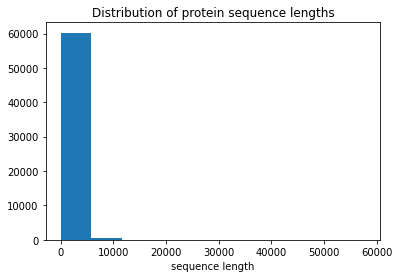

In [ ]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [ ]:
# remove proteins with lengths > 2000 to save compute time on LSTM models
max_len = 2000
df = df[df['residueCount'] < max_len]
print("Total number of unique proteins:", len(df))
print("Total number of unique classification labels:", len(df.classification.unique()))

Total number of unique proteins: 57359
Total number of unique classification labels: 2052


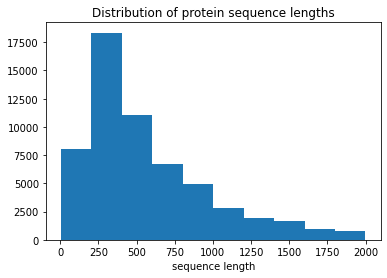

In [ ]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [ ]:
# keep only 15 most important classes by instance count
N_class = 15
count = Counter(df.classification)
sort = count.most_common()[:N_class]
classes = np.array(sort)[:, 0]
df = df[[c in classes for c in df.classification]]
sequences = df.sequence.values
print("Total number of unique proteins:", len(df))

In [ ]:
df.classification.value_counts()

HYDROLASE                            9704
TRANSFERASE                          7277
OXIDOREDUCTASE                       5544
IMMUNE SYSTEM                        2333
LYASE                                2177
TRANSCRIPTION                        1660
TRANSPORT PROTEIN                    1608
HYDROLASE/HYDROLASE INHIBITOR        1457
SIGNALING PROTEIN                    1286
TRANSFERASE/TRANSFERASE INHIBITOR    1242
ISOMERASE                            1205
LIGASE                               1000
VIRAL PROTEIN                         944
PROTEIN BINDING                       861
MEMBRANE PROTEIN                      772
Name: classification, dtype: int64

In [ ]:
# one hot encode classes
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

# tokenize our sequences
# create fit
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(sequences)
X = sequence.pad_sequences(X, maxlen=max_len)
print('X shape:', X.shape, 'Y shape:', Y.shape)

X shape: (39070, 2000) Y shape: (39070, 15)


In [ ]:
# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
X_train = th.from_numpy(X_train)
X_test = th.from_numpy(X_test)
y_train = th.from_numpy(y_train)
y_test = th.from_numpy(y_test)

### Save/Load PyTorch tensors
prevents from loading whole dataset which takes time


In [29]:
# to save/load model on your google drive, you need to mount it first
# follow instructions.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# save
work_dir = f'/content/gdrive/My Drive/Colab Notebooks/Data'
th.save(X_train, os.path.join(work_dir, 'X_train.pt'))
th.save(X_test, os.path.join(work_dir, 'X_test.pt'))
th.save(y_train, os.path.join(work_dir,'y_train.pt'))
th.save(y_test, os.path.join(work_dir, 'y_test.pt'))

In [5]:
# load
work_dir = f'/content/gdrive/My Drive/Colab Notebooks/Data'
X_train = th.load(os.path.join(work_dir, 'X_train.pt'))
Data_test = th.load(os.path.join(work_dir, 'X_test.pt'))
y_train = th.load(os.path.join(work_dir,'y_train.pt'))
Label_test = th.load(os.path.join(work_dir, 'y_test.pt'))
assert len(X_train) == len(y_train)
assert len(Data_test) == len(Label_test)
print('Nb training examples:', len(X_train))
print('Nb test examples:', len(Data_test))

Nb training examples: 31256
Nb test examples: 7814


GPU compute setup

In [28]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
# pass train/test variables to torch detected device 
# X_train, X_test = X_train.to(device), X_test.to(device)
# y_train, y_test = y_train.to(device), y_test.to(device)
# sanity check 
# X_train.is_cuda


## Model

In [12]:
# Hyperparameters
vocab_size = len(th.unique(X_train)) # number of unique amino acids
sequence_length = 2000 # maximum length of sequence
embedding_size = 11 # 
num_layers = 2 # number of layers for BiLTSM model
hidden_size = 256
num_classes = 15 # number of protein
lr = 0.001
batch_size = 32
n_epochs = 10


In [13]:
class Dataset(th.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
        self.list_IDs = [i for i in range(len(X))]

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = self.X[ID]
        y = self.y[ID]
        return X, y

In [30]:
class BiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size):
    """
    vocab_size: int, number of words in vocbulary
    emedding_size: int, embedding dimension
    hidden_size: int, size of hidden layer
    num_layers: int, number of LSTM layers
    num_classes: number of classes
    batch_size: size of mini batches
    """
    super(BiLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    # self.hidden = self.init_hidden()
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.linear = nn.Linear(hidden_size*2, num_classes)
  
  def init_hidden(self):
    # initialise hidden & cell state
    h0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    c0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    return (h0, c0)

  def forward(self, inputs, hidden):
    x = self.embedding(inputs) # x=[batch_size, sequence_len, embedding_size]
    # lstm_out, self.hidden = self.lstm(x, self.hidden) # lstm_out=[batch_size, sequence_len, hidden_size]
    lstm_out, hidden = self.lstm(x, hidden)
    lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size]
    y = self.linear(lstm_out[-1]) # take last hidden state, y=[batch_size, num_classes]
    probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
    return probs, hidden

# generate model instance
model1 = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size).to(device)
print(model1)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer1, step_size=1., gamma=0.1)

BiLSTM(
  (embedding): Embedding(26, 11)
  (lstm): LSTM(11, 256, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=15, bias=True)
)


#### Utils

In [ ]:
# visualize tensor dimensions after each layer
batch, label = list(train_generator)[0]
label = th.argmax(label, 1)
batch = batch.to(device)
emb = nn.Embedding(vocab_size, embedding_size).to(device)
lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True).to(device)
h0 = Variable(th.zeros(num_layers*2, batch_size, hidden_size)).to(device)
c0 = Variable(th.zeros(num_layers*2, batch_size, hidden_size)).to(device)
lin = nn.Linear(hidden_size*2, num_classes).to(device)
emb_out = emb(batch)
print(emb_out.size())
lstm_out, _ = lstm(emb_out, (h0, c0))
print(lstm_out.size())
lstm_out = lstm_out.permute(1,0,2)
lstm_out = lstm_out[-1]
print(lstm_out.size())
lin_out = lin(lstm_out)
print(lin_out.size())
y = F.log_softmax(lin_out, dim=1)
print(y.size())
l = criterion1(y, label)
print('loss = {}'.format(l))

In [31]:
def repackage_hidden(h):
  hn, cn = h[0], h[1]
  return Variable(hn), Variable(cn)

In [16]:
def train(dataloader, model, optimizer, criterion):
  """
  Main function for training model and printing prompt
  """
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 300
  start_time = time.time()

  for idx, (batch, label) in enumerate(dataloader):
    hidden = model.init_hidden() # initalise hidden states
    model.zero_grad()
    pred, hidden = model(batch, hidden)
    hidden = repackage_hidden(hidden)
    label = th.argmax(label, 1) # one_hot --> indexing
    loss = criterion(pred, label)
    loss.backward()
    th.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    total_acc += (pred.argmax(1) == label).sum().item()
    total_count += label.size(0)
    if idx % log_interval == 0 and idx > 0:
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5d}/{:5d} batches '
              '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
        total_acc, total_count = 0, 0
        start_time = time.time()

def evaluate(dataloader, model, criterion):
  """
  Main function for training model and printing prompt
  """
  model.eval()
  total_acc, total_count = 0, 0

  with th.no_grad():
    for idx, (batch, label) in enumerate(dataloader):
      hidden = model.init_hidden() # initalise hidden states
      pred, hidden = model(batch, hidden)
      hidden = repackage_hidden(hidden) # repackage to prevent backpropagation through whole training example
      label = th.argmax(label, 1) # one_hot --> indexing
      loss = criterion(pred, label)
      total_acc += (pred.argmax(1) == label).sum().item()
      total_count += label.size(0)
  return total_acc/total_count

#### Training

In [32]:
# Train/Val/Test generators
X_val, X_test, y_val, y_test = train_test_split(Data_test, Label_test, test_size=.5)
train_set = Dataset(X_train, y_train)
train_generator = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_set = Dataset(X_val, y_val)
val_generator = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_set = Dataset(X_test, y_test)
test_generator = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)
print('Nb training examples:', len(X_train))
print('Nb validation examples:', len(X_val))
print('Nb test examples:', len(X_test))

Nb training examples: 31256
Nb validation examples: 3907
Nb test examples: 3907


In [35]:
# training loop
save_dir = f'/content/gdrive/My Drive/Colab Notebooks/Weights'
date = datetime.now().strftime("%Y%m%d-%I%M_%p")

total_accu=None
train_acc = []
val_acc = []


for epoch in range(1, n_epochs+ 1):
  epoch_start_time = time.time()
  train(train_generator, model1, optimizer1, criterion1)
  accu_train = evaluate(train_generator, model1, criterion1)
  train_acc.append(accu_train)
  accu_val = evaluate(val_generator, model1, criterion1)
  val_acc.append(accu_val)
  th.save({'epoch': epoch,
              'model_state_dict': model1.state_dict(),
              'optimizer_state_dict': optimizer1.state_dict(),
              'loss': criterion1}, 
             os.path.join(save_dir, 'bilstm'+'_'+ date + '.pt'))
  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
      total_accu = accu_val
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'val accuracy {:8.3f} '.format(epoch,time.time()-epoch_start_time,accu_val))
  print('-' * 59)


| epoch   1 |   300/  976 batches | accuracy    0.294
| epoch   1 |   600/  976 batches | accuracy    0.338
| epoch   1 |   900/  976 batches | accuracy    0.374
-----------------------------------------------------------
| end of epoch   1 | time: 560.98s | val accuracy    0.383 
-----------------------------------------------------------
| epoch   2 |   300/  976 batches | accuracy    0.415
| epoch   2 |   600/  976 batches | accuracy    0.438
| epoch   2 |   900/  976 batches | accuracy    0.470
-----------------------------------------------------------
| end of epoch   2 | time: 565.66s | val accuracy    0.480 
-----------------------------------------------------------
| epoch   3 |   300/  976 batches | accuracy    0.524
| epoch   3 |   600/  976 batches | accuracy    0.540
| epoch   3 |   900/  976 batches | accuracy    0.573
-----------------------------------------------------------
| end of epoch   3 | time: 565.83s | val accuracy    0.567 
----------------------------------

In [41]:
def plot_acc(train_acc, val_acc, nb_epochs):

  x = range(1, nb_epochs+1)
  plt.figure()
  plt.plot(x, train_acc, color='blue')
  plt.plot(x, val_acc, color='orange')
  plt.xlabel('epochs')
  plt.ylabel('accuracy %')
  plt.show()


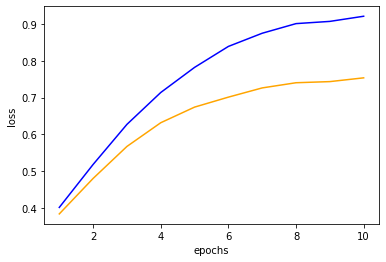

In [40]:
plot_loss(train_loss, val_loss, n_epochs)